In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report,roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

---
## Compare Models

In [2]:
#We implement a class of methods to call all previous steps into one unique cell.
class classi:
    def __init__(self,estimators):
        self.algo=estimators
        self.best_estimateurs={}
     #Fitting the models before the prediction phase
    
    #Prediction used on the test set for all our models
    def pred(self,x_train,y_train,x_test,y_test):
        pred={}
        for estim in self.algo:
            self.algo[estim]['mod'].fit(x_train,y_train)
            pred[estim]=self.algo[estim]['mod'].predict(x_test)
        return pred
    
    def roc_curve(self,pred):
        plt.figure(figsize=(10,5))
        for estim in pred.keys():
            fpr,tpr,threshold = roc_curve(y_test,pred[estim])
            sns.set_style('whitegrid')
            plt.title('Receiver Operating Characteristic Curve')
            plt.plot(fpr,tpr,label=f'{estim}')
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.legend()
        plt.show()
    
    def show_score(self,y_test,pred):
        conf_mat={}
        acc_score={}
        for estim in self.algo:
            print(f"--------------{estim}---------------------------------------------------------------------")
            conf_mat[estim]=confusion_matrix(y_test,pred[estim])
            acc_score[estim]=accuracy_score(y_test,pred[estim])
            print(f'Using the confusion matrix, we have : \n {conf_mat[estim]}')
            print('\n')
            print(f'The accuracy score of {estim} is:\n {acc_score[estim]*100}')
            print('\n')
            print('We present the classification report with all the metrics related to the predictive score')
            print(classification_report(y_test,pred[estim]))
            print(f"*"*40)
            print("\n")
        return acc_score

    def model_eval(self,acc_score):
        accuracy=acc_score.copy()
        accuracy.update((x,y*100) for x,y in acc_score.items())
        models=list(acc_score.keys())
        scores=list(accuracy.values())
        mod_ev=pd.DataFrame({'Model':models,'Accuracy':scores})
        mod_ev
        return mod_ev

In [3]:
def compareModels(x_train, x_test, y_train, y_test):
    #Improve the Decision Tree Model
    #Using grid search, the parameters of max_depth and min_samples_split are adjusted in a small range
    param_grid = {
        'max_depth':np.arange(2, 6),
        'min_samples_split':np.arange(2, 18)}

    rfc = DecisionTreeClassifier(random_state=10)
    GS = GridSearchCV(rfc,param_grid,cv=10)
    GS.fit(x_train,y_train)
    dt = [GS.best_params_['max_depth'],GS.best_params_['min_samples_split']]
    print("Decision Tree Model:")
    print(GS.best_params_)
    print("Best Score: " + str(GS.best_score_))
    print("")

    #Improve the Random Forest Model
    #Using grid search, the parameters of max_depth and min_samples_split are adjusted in a small range
    param_grid = {
        'max_depth':np.arange(2, 6),
        'min_samples_split':np.arange(2, 10)}

    rfc = RandomForestClassifier(random_state=10)
    GS = GridSearchCV(rfc,param_grid,cv=10)
    GS.fit(x_train,y_train)
    rf = [GS.best_params_['max_depth'],GS.best_params_['min_samples_split']]
    print("Random Forest Model:")
    print(GS.best_params_)
    print("Best Score: " + str(GS.best_score_))
    print("")

    #Improve the Logistic Regression Model
    #Using grid search, the parameter of max_iter is adjusted in a small range
    param_grid = {
        'max_iter':np.arange(300, 2000,100)}

    rfc = LogisticRegression(solver='lbfgs')
    GS = GridSearchCV(rfc,param_grid,cv=10)
    GS.fit(x_train,y_train)
    lg = GS.best_params_['max_iter']
    print("Logistic Regression Model:")
    print(GS.best_params_)
    print("Best Score: " + str(GS.best_score_))
    print("")

    #Improve the LightGBM Model
    #Using grid search, the parameters of max_depth and num_leaves are adjusted in a small range
    param_grid = {
        'max_depth':np.arange(2, 6),
        'num_leaves':np.arange(2, 18)}

    rfc = LGBMClassifier(random_state=10)
    GS = GridSearchCV(rfc,param_grid,cv=10)
    GS.fit(x_train,y_train)
    lgb = [GS.best_params_['max_depth'],GS.best_params_['num_leaves']]
    print("LightGBM Model:")
    print(GS.best_params_)
    print("Best Score: " + str(GS.best_score_))
    print("")

    # Estimators to be called 
    estimators={"Decision Trees":{"mod":DecisionTreeClassifier(max_depth= dt[0], min_samples_split= dt[1], random_state=10),"param":0},
               "Random Forest":{'mod':RandomForestClassifier(max_depth=rf[0], min_samples_split=rf[1], random_state=10),"param":0},
               'Naive Bayes':{"mod":GaussianNB(),"param":0},
               'Logistic Regression':{"mod": LogisticRegression(solver='lbfgs', max_iter=lg),"param":0},
               "LightGBM":{"mod": LGBMClassifier(max_depth= lgb[0], num_leaves= lgb[1], random_state=10),"param":0}}

    classification= classi(estimators)
    pred=classification.pred(x_train,y_train,x_test,y_test)
#     classification.roc_curve(pred)
    acc_score=classification.show_score(y_test,pred)
    model_ev=classification.model_eval(acc_score)
    print(model_ev)

---
# Yahoo S&P 500 Health Care Sector Data

In [31]:
import yfinance as yf
from collections import deque 

In [32]:
SPHC = yf.download('^SP500-35', start='2019-09-05', end='2022-06-17')

[*********************100%***********************]  1 of 1 completed


In [33]:
SPHC.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-05,1047.000000,1052.969971,1043.900024,1050.459961,1050.459961,151221300
2019-09-06,1052.619995,1056.599976,1051.689941,1053.739990,1053.739990,156235900
2019-09-09,1053.819946,1054.609985,1040.189941,1044.069946,1044.069946,185006400
2019-09-10,1041.969971,1047.119995,1027.660034,1047.119995,1047.119995,230308700
2019-09-11,1047.939941,1057.709961,1046.369995,1057.709961,1057.709961,168617800


In [34]:
SPHC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 702 entries, 2019-09-05 to 2022-06-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       702 non-null    float64
 1   High       702 non-null    float64
 2   Low        702 non-null    float64
 3   Close      702 non-null    float64
 4   Adj Close  702 non-null    float64
 5   Volume     702 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 38.4 KB


In [35]:
# Preprocess Data

# Store Date and Change Index
SPHC["Date"] = SPHC.index
index = pd.Index(range(0, len(SPHC)))
SPHC = SPHC.set_index(index)

# Diff
SPHC['Diff'] = SPHC['High'] - SPHC['Low']

# Diff20
Diff20 = [None for i in range(19)]
Diff20sum = 0

# DiffChange
DiffChange = [None for i in range(20)]

# Return
Return = [None]

# Return5
Return5 = [None for i in range(5)]

# Return10
Return10 = [None for i in range(10)]

# MA10
MA10 = [None for i in range(9)]
MA10sum = 0

# MA30
MA30 = [None for i in range(29)]
MA30sum = 0

# MA100
MA100 = [None for i in range(99)]
MA100sum = 0

# MA10-30
MA1030 = [None for i in range(29)]

# MA30-100
MA30100 = [None for i in range(99)]

# High30
High30 = [None for i in range(29)]
High30q = deque()

# Low30
Low30 = [None for i in range(29)]
Low30q = deque()

# Break30
Break30 = [None for i in range(30)]

# Vol20
Vol20 = [None for i in range(20)]
Vol20q = deque()

# Label
Label = [None for i in range(99)]

for i in range(len(SPHC)):
    curr = SPHC.loc[i]["Adj Close"]
    
    # Diff20
    Diff20sum+=SPHC.loc[i]['Diff']
    if i>19:
        Diff20sum-=SPHC.loc[i-20]['Diff']
    if i>18:
        Diff20.append(Diff20sum/20)
    
    # DiffChange:
    if i>19:
        if SPHC.loc[i]['Diff']>Diff20[i-1]:
            DiffChange.append(1)
        elif SPHC.loc[i]['Diff']==Diff20[i-1]:
            DiffChange.append(0)
        else:
            DiffChange.append(-1)
    
    # Return
    if i>0:
        prev = SPHC.loc[i-1]["Adj Close"]
        Return.append((curr - prev)/prev*100)
    
    # Return5
    if i>4:
        prev5 = SPHC.loc[i-5]["Adj Close"]
        Return5.append((curr - prev5)/prev5*100)
        
    # Return10
    if i>9:
        prev10 = SPHC.loc[i-10]["Adj Close"]
        Return10.append((curr - prev10)/prev10*100)
    
    # MA10
    MA10sum+=curr
    if i>9:
        MA10sum-=SPHC.loc[i-10]['Adj Close']
    if i>8:
        MA10.append(MA10sum/10)
    
    # MA30
    MA30sum+=curr
    if i>29:
        MA30sum-=SPHC.loc[i-30]['Adj Close']
    if i>28:
        MA30.append(MA30sum/30)
    
    # MA100
    MA100sum+=curr
    if i>99:
        MA100sum-=SPHC.loc[i-100]['Adj Close']
    if i>98:
        MA100.append(MA100sum/100)
    
    # MA10-30
    if i>28:
        if MA10[i]>MA30[i]:
            MA1030.append(1)
        elif MA10[i]==MA30[i]:
            MA1030.append(0)
        else:
            MA1030.append(-1)
    
    # MA30-100
    if i>98:
        if MA30[i]>MA100[i]:
            MA30100.append(1)
        elif MA30[i]==MA100[i]:
            MA30100.append(0)
        else:
            MA30100.append(-1)
    
    # High30
    while High30q and curr>High30q[-1]:
        High30q.pop()
    High30q.append(curr)
    if i>29 and High30q[0] == SPHC.loc[i-30]['Adj Close']:
        High30q.popleft()
    if i>28:
        High30.append(High30q[0])
    
    # Low30
    while Low30q and curr<Low30q[-1]:
        Low30q.pop()
    Low30q.append(curr)
    if i>29 and Low30q[0] == SPHC.loc[i-30]['Adj Close']:
        Low30q.popleft()
    if i>28:
        Low30.append(Low30q[0])
    
    # Break 30
    if i>=30:
        if curr>High30[i-1]:
            Break30.append(1)
        elif curr<Low30[i-1]:
            Break30.append(-1)
        else:
            Break30.append(0)
    
    # Vol20
    if i>0:
        Vol20q.append(Return[i])
    if len(Vol20q)>20:
        Vol20q.popleft()
    if i>19:
        Vol20.append(np.std(Vol20q))
        
# Label
for i in range(99, len(SPHC)):
    if i<len(SPHC)-10:
        if Return10[i+10]>0:
            Label.append(1)
        elif Return10[i+10]==0:
            Label.append(0)
        else:
            Label.append(-1)
    else:
        Label.append(None)
            
        
SPHC["Diff20"] = Diff20
SPHC["DiffChange"] = DiffChange
SPHC["Return"] = Return
SPHC["Return5"] = Return5
SPHC["MA10"] = MA10
SPHC["MA30"] = MA30
SPHC["MA100"] = MA100
SPHC["MA1030"] = MA1030
SPHC["MA30100"] = MA30100
SPHC["High30"] = High30
SPHC["Low30"] = Low30
SPHC["Break30"] = Break30
SPHC["Vol20"] = Vol20
SPHC["Label"] = Label

In [36]:
# Drop None Rows
SPHC.drop([len(SPHC)-i for i in range(1,11)], inplace = True)
SPHC.drop([i for i in range(99)], inplace = True)

# Select features
SPHC = SPHC[["Date","High","Low","Volume","Diff","DiffChange","Return","Return5","MA1030","MA30100","Break30","Vol20","Label"]]

# Reset Index
index = pd.Index(range(0, len(SPHC)))
SPHC = SPHC.set_index(index)
SPHC = SPHC.astype({'Label':'int'})
SPHC['Date'] = SPHC['Date'].dt.strftime('%Y-%m-%d')
SPHC.to_csv('SPHC.csv')
SPHC

,Date,High,Low,Volume,Diff,DiffChange,Return,Return5,MA1030,MA30100,Break30,Vol20,Label
0,2020-01-28,1194.689941,1184.349976,202157900,10.339966,1.0,0.477113,-2.326380,1.0,1.0,0.0,0.617034,1
1,2020-01-29,1195.069946,1186.439941,166189700,8.630005,-1.0,-0.279020,-2.713914,1.0,1.0,0.0,0.602541,1
2,2020-01-30,1179.380005,1167.339966,199618700,12.040039,1.0,-0.775370,-2.987806,1.0,1.0,0.0,0.621944,1
3,2020-01-31,1173.199951,1150.369995,228459400,22.829956,1.0,-1.985833,-3.292691,1.0,1.0,-1.0,0.748871,1
4,2020-02-03,1172.630005,1161.109985,207902400,11.520020,1.0,0.925513,-1.652574,-1.0,1.0,0.0,0.765988,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2022-05-26,1538.979980,1526.260010,178529300,12.719971,-1.0,0.415281,2.741086,-1.0,-1.0,0.0,1.343798,-1
589,2022-05-27,1559.339966,1529.569946,185013000,29.770020,-1.0,1.717533,3.205348,-1.0,-1.0,0.0,1.277321,-1
590,2022-05-31,1559.339966,1525.959961,362578700,33.380005,1.0,-1.373653,0.975666,-1.0,-1.0,0.0,1.308182,-1
591,2022-06-01,1543.839966,1504.239990,159014200,39.599976,1.0,-1.423352,-0.714495,-1.0,-1.0,0.0,1.348318,-1


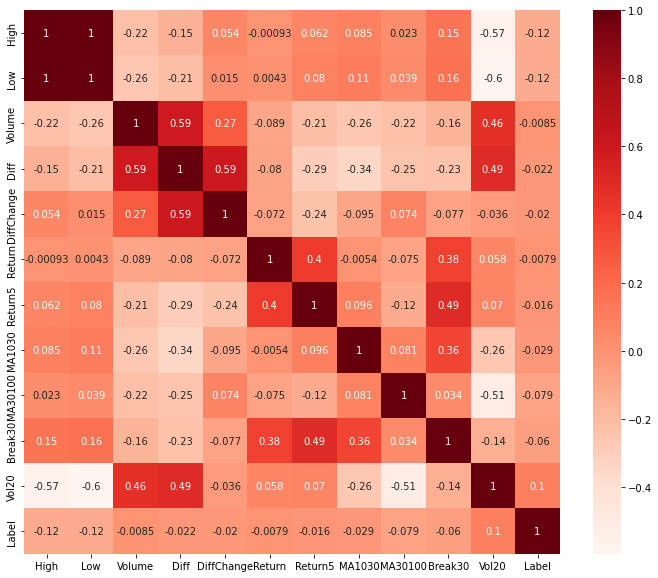

In [37]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = SPHC.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
# Split Train/Test Data and Compare Models
data = SPHC
list_features = list(data)
list_features.remove('Date')
list_features.remove('Label')
x = data[list_features]
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=7)
compareModels(x_train, x_test, y_train, y_test)

Decision Tree Model:
{'max_depth': 5, 'min_samples_split': 8}
Best Score: 0.6846689895470383

Random Forest Model:
{'max_depth': 5, 'min_samples_split': 3}
Best Score: 0.6918118466898954

Logistic Regression Model:
{'max_iter': 300}
Best Score: 0.5831591173054587

LightGBM Model:
{'max_depth': 2, 'num_leaves': 4}
Best Score: 0.701567944250871

--------------Decision Trees---------------------------------------------------------------------
Using the confusion matrix, we have : 
 [[38 27]
 [32 81]]


The accuracy score of Decision Trees is:
 66.85393258426966


We present the classification report with all the metrics related to the predictive score
              precision    recall  f1-score   support

          -1       0.54      0.58      0.56        65
           1       0.75      0.72      0.73       113

    accuracy                           0.67       178
   macro avg       0.65      0.65      0.65       178
weighted avg       0.67      0.67      0.67       178

****************

---
## Twitter Data:

In [12]:
# Match Twitter with SPHC
Twitter = pd.read_csv("output_percent.csv")
i = 0
j = 0
while j < len(SPHC):
    if str(Twitter.loc[i]["tweet_timestamp"]) != str(SPHC.loc[j]["Date"]):
        Twitter.drop([i], inplace=True)
        j-=1
    i+=1
    j+=1
Twitter = Twitter.reset_index(drop = True)
Twitter["Label"] = SPHC["Label"]
Twitter

,tweet_timestamp,count,sent_-2,sent_-1,sent_0,sent_1,sent_2,emo_A,emo_F,emo_H,emo_S,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,Label
0,2020-01-28,9327.000000,0.045138,0.657339,0.142918,0.151067,0.003538,0.187198,0.487617,0.154605,0.027662,0.438082,0.495200,0.445539,0.287662,0.424826,1
1,2020-01-29,14628.000000,0.053322,0.628589,0.158942,0.156276,0.002871,0.194011,0.461786,0.159147,0.026114,0.437354,0.494122,0.448490,0.290009,0.428533,1
2,2020-01-30,15063.000000,0.048861,0.640443,0.143531,0.164509,0.002656,0.195579,0.469495,0.167165,0.024232,0.438925,0.493577,0.446161,0.289947,0.426665,1
3,2020-01-31,11608.666667,0.044450,0.636794,0.146672,0.168753,0.003331,0.194711,0.461695,0.172084,0.024838,0.441726,0.488082,0.444245,0.290290,0.423104,1
4,2020-02-03,8758.000000,0.045444,0.616922,0.156771,0.176068,0.004796,0.154145,0.483900,0.180863,0.024321,0.444986,0.494471,0.437506,0.293145,0.422798,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2022-05-26,25173.000000,0.087792,0.570015,0.128789,0.203551,0.009852,0.302944,0.296031,0.213403,0.058833,0.438813,0.472392,0.466321,0.277238,0.438498,-1
589,2022-05-27,21483.000000,0.080901,0.565036,0.131810,0.212742,0.009511,0.309919,0.270338,0.222253,0.065680,0.441824,0.465745,0.465945,0.283419,0.435830,-1
590,2022-05-31,26312.000000,0.074453,0.565445,0.143889,0.207662,0.008551,0.300395,0.275844,0.216213,0.063659,0.443052,0.465012,0.463310,0.281286,0.434718,-1
591,2022-06-01,25473.000000,0.079025,0.554941,0.134652,0.219605,0.011777,0.307463,0.265340,0.231382,0.061163,0.444818,0.464235,0.463651,0.283742,0.434242,-1


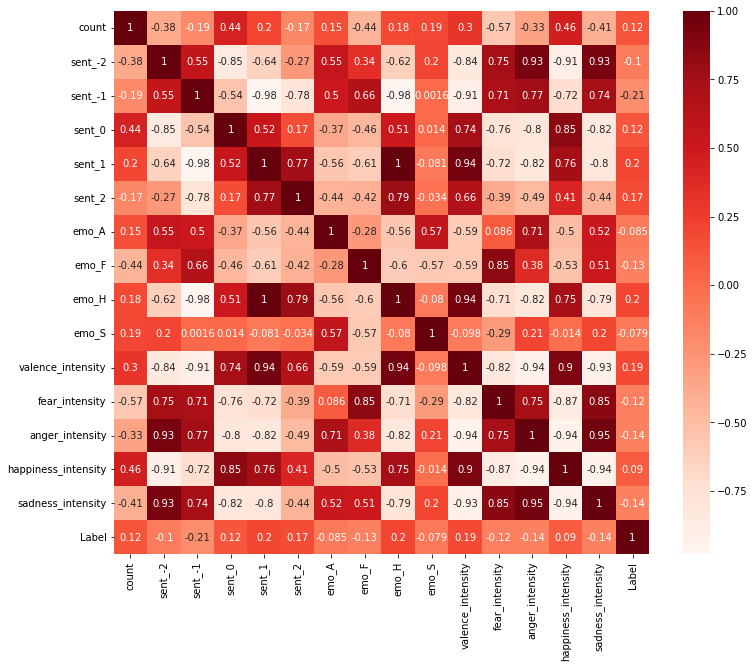

In [13]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = Twitter.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
# Split Train/Test Data and Compare Models
data = Twitter
list_features = list(data)
list_features.remove('tweet_timestamp')
list_features.remove('Label')
x = data[list_features]
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=7)
compareModels(x_train, x_test, y_train, y_test)

Decision Tree Model:
{'max_depth': 4, 'min_samples_split': 5}
Best Score: 0.6292102206736352

Random Forest Model:
{'max_depth': 4, 'min_samples_split': 3}
Best Score: 0.6580139372822299

Logistic Regression Model:
{'max_iter': 300}
Best Score: 0.5831591173054587

LightGBM Model:
{'max_depth': 5, 'num_leaves': 12}
Best Score: 0.6722996515679442

--------------Decision Trees---------------------------------------------------------------------
Using the confusion matrix, we have : 
 [[38 27]
 [34 79]]


The accuracy score of Decision Trees is:
 65.73033707865169


We present the classification report with all the metrics related to the predictive score
              precision    recall  f1-score   support

          -1       0.53      0.58      0.55        65
           1       0.75      0.70      0.72       113

    accuracy                           0.66       178
   macro avg       0.64      0.64      0.64       178
weighted avg       0.67      0.66      0.66       178

**************

---
## MergeData: Yahoo Finance Data + Twitter Data

In [15]:
MergeData = pd.merge(Twitter, SPHC, left_on='tweet_timestamp',right_on='Date',how='right')
MergeData

,tweet_timestamp,count,sent_-2,sent_-1,sent_0,sent_1,sent_2,emo_A,emo_F,emo_H,...,Volume,Diff,DiffChange,Return,Return5,MA1030,MA30100,Break30,Vol20,Label_y
0,2020-01-28,9327.000000,0.045138,0.657339,0.142918,0.151067,0.003538,0.187198,0.487617,0.154605,...,202157900,10.339966,1.0,0.477113,-2.326380,1.0,1.0,0.0,0.617034,1
1,2020-01-29,14628.000000,0.053322,0.628589,0.158942,0.156276,0.002871,0.194011,0.461786,0.159147,...,166189700,8.630005,-1.0,-0.279020,-2.713914,1.0,1.0,0.0,0.602541,1
2,2020-01-30,15063.000000,0.048861,0.640443,0.143531,0.164509,0.002656,0.195579,0.469495,0.167165,...,199618700,12.040039,1.0,-0.775370,-2.987806,1.0,1.0,0.0,0.621944,1
3,2020-01-31,11608.666667,0.044450,0.636794,0.146672,0.168753,0.003331,0.194711,0.461695,0.172084,...,228459400,22.829956,1.0,-1.985833,-3.292691,1.0,1.0,-1.0,0.748871,1
4,2020-02-03,8758.000000,0.045444,0.616922,0.156771,0.176068,0.004796,0.154145,0.483900,0.180863,...,207902400,11.520020,1.0,0.925513,-1.652574,-1.0,1.0,0.0,0.765988,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,2022-05-26,25173.000000,0.087792,0.570015,0.128789,0.203551,0.009852,0.302944,0.296031,0.213403,...,178529300,12.719971,-1.0,0.415281,2.741086,-1.0,-1.0,0.0,1.343798,-1
589,2022-05-27,21483.000000,0.080901,0.565036,0.131810,0.212742,0.009511,0.309919,0.270338,0.222253,...,185013000,29.770020,-1.0,1.717533,3.205348,-1.0,-1.0,0.0,1.277321,-1
590,2022-05-31,26312.000000,0.074453,0.565445,0.143889,0.207662,0.008551,0.300395,0.275844,0.216213,...,362578700,33.380005,1.0,-1.373653,0.975666,-1.0,-1.0,0.0,1.308182,-1
591,2022-06-01,25473.000000,0.079025,0.554941,0.134652,0.219605,0.011777,0.307463,0.265340,0.231382,...,159014200,39.599976,1.0,-1.423352,-0.714495,-1.0,-1.0,0.0,1.348318,-1


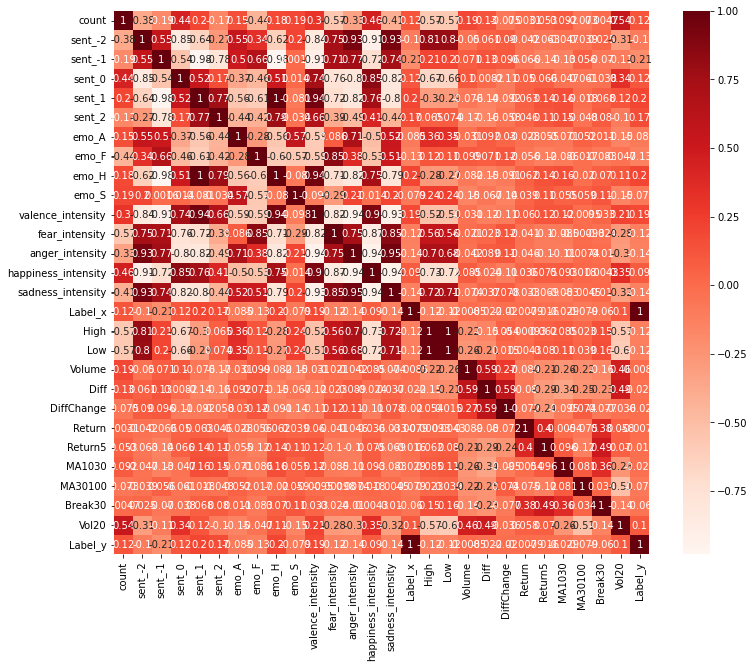

In [16]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = MergeData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [17]:
cor = MergeData.corr()

#Correlation with output variable
cor_target = abs(cor["Label_y"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
list(relevant_features.index)

['count',
 'sent_-2',
 'sent_-1',
 'sent_0',
 'sent_1',
 'sent_2',
 'emo_A',
 'emo_F',
 'emo_H',
 'emo_S',
 'valence_intensity',
 'fear_intensity',
 'anger_intensity',
 'happiness_intensity',
 'sadness_intensity',
 'Label_x',
 'High',
 'Low',
 'MA30100',
 'Break30',
 'Vol20',
 'Label_y']

In [18]:
# Split Train/Test Data and Compare Models
data = MergeData
list_features = list(relevant_features.index)
list_features.remove('Label_x')
list_features.remove('Label_y')
x = data[list_features]
y = data['Label_y']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state=7)
compareModels(x_train, x_test, y_train, y_test)

Decision Tree Model:
{'max_depth': 5, 'min_samples_split': 13}
Best Score: 0.7324041811846689

Random Forest Model:
{'max_depth': 5, 'min_samples_split': 2}
Best Score: 0.7252613240418118

Logistic Regression Model:
{'max_iter': 300}
Best Score: 0.5832752613240417

LightGBM Model:
{'max_depth': 5, 'num_leaves': 10}
Best Score: 0.7758420441347271

--------------Decision Trees---------------------------------------------------------------------
Using the confusion matrix, we have : 
 [[50 15]
 [39 74]]


The accuracy score of Decision Trees is:
 69.66292134831461


We present the classification report with all the metrics related to the predictive score
              precision    recall  f1-score   support

          -1       0.56      0.77      0.65        65
           1       0.83      0.65      0.73       113

    accuracy                           0.70       178
   macro avg       0.70      0.71      0.69       178
weighted avg       0.73      0.70      0.70       178

*************